In [1]:
import pandas as pd
from scipy.sparse import csr_matrix, diags
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
import time
import matplotlib.pyplot as plt

import sys
sys.path += ['Package/']  

from node2vec.model import Node2Vec

from node_embedding import *
from dcsbm import *

import warnings
warnings.filterwarnings("ignore")

directory = 'dataset/'

Number of nodes: 9317
Number of clusters: 232


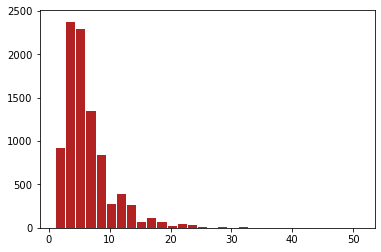

In [17]:
# The datasets are ['amazon', 'dblp', 'livejournal', 'orkut', 'youtube']

name = 'amazon'

EL = pd.read_csv(directory + name + '.csv')[['id1', 'id2']]
n = len(pd.concat([EL.id1, EL.id2]).unique())

ℓtrue = pd.read_csv(directory + name + '_label.csv').set_index('node')
ℓtrue = ℓtrue.loc[np.arange(n)].label.values
n_clusters = len(np.unique(ℓtrue))


print("Number of nodes: " + str(n))
print("Number of clusters: " + str(n_clusters))


A = csr_matrix((np.ones(len(EL)), (EL.id1, EL.id2)), shape = (n,n))
d = A@np.ones(A.shape[0])

plt.hist(d, bins = 30, color = 'firebrick', edgecolor = 'white')
plt.show();

In [15]:
# Our method

t0 = time.time()

d = A@np.ones(n)
D_1 = diags(d**(-1))
P = D_1.dot(A)

Pv = [P]
dim = 32

t0 = time.time()
Φ = NodeEmbedding(A, dim, γ = 0., η0 = 0.85, n_epochs = 50, n_prod = 1, verbose = True)
print("\n\nExecution time: " + str(time.time() - t0) + "\n")
print(computeScore(Φ, ℓtrue, False))

Running the optimization for k = 1
[========================>] 100%

Execution time: 3.4359850883483887

0.4988779441866272


In [28]:
# t0 = time.time()
# X = Node2VecNS(A, dim, verbose = False)
# print("\nExecution time: " + str(time.time() - t0) + "\n\n")
# print(computeScore(X, ℓtrue))

        

| Dataset     | NMI us | NMI NS | t us | t NS  |
| -------     | ------ | ------ | ---- | ----- |
| amazon      | 0.92   | 0.92   | 2.   | 15.   |
| dblp        | 0.51   | 0.52   | 17   | 135   |
| livejournal | 0.91   | 0.50   | 23   | 135   |
| youtube     | 0.58   | 0.65   | 6    | 57    |


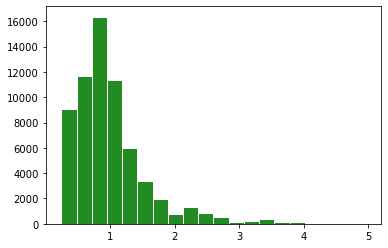

In [29]:
plt.hist(np.sqrt(Φ**2@np.ones(dim)), bins = 20, edgecolor = 'white', color = 'forestgreen')
plt.show();